# Notebook for visualizing streaming data

In [1]:
import fastplotlib as fpl 
import numpy as np
import zmq
import tifffile
import scipy
import queue 

fastplotlib version from git (0.4.0) and __version__ (0.5.0) don't match.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


Image(value=b'version https://git-lfs.github.com/spec/...', height='55', width='300')

Valid,Device,Type,Backend,Driver
✅,Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,Vulkan,Mesa 25.0.4
✅ (default),NVIDIA GeForce RTX 4060 Laptop GPU,DiscreteGPU,Vulkan,565.77
❗ limited,"llvmpipe (LLVM 19.1.7, 256 bits)",CPU,Vulkan,Mesa 25.0.4 (LLVM 19.1.7)
❌,Mesa Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,OpenGL,4.6 (Core Profile) Mesa 25.0.4


Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


# Calculate seeded median

In [2]:
file_path = "/home/clewis/repos/holo-nbs/rb26_20240111/raw_voltage_chunk.tif"
data = tifffile.memmap(file_path)
data.shape

(384, 3000001)

In [3]:
# define filter functions
def butter(cutoff, fs, order=5, btype='high'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a


def butter_filter(data, cutoff, fs, order=5, axis=-1, btype='high'):
    b, a = butter(cutoff, fs, order=order, btype=btype)
    y = scipy.signal.filtfilt(b, a, data, axis=axis)
    return y

In [4]:
median = np.median(butter_filter(data[:, :4000], 1_000, 30_000), axis=1)

# Setup zmq subscriber

In [5]:
context = zmq.Context()
sub = context.socket(zmq.SUB)
sub.setsockopt(zmq.SUBSCRIBE, b"")

# keep only the most recent message
sub.setsockopt(zmq.CONFLATE, 1)

# address must match publisher in actor
sub.connect("tcp://127.0.0.1:5557")

<SocketContext(connect='tcp://127.0.0.1:5557')>

In [6]:
def get_buffer():
    """Gets the buffer from the publisher."""
    try:
        b = sub.recv(zmq.NOBLOCK)
    except zmq.Again:
        pass
    else:
        return b
    
    return None

# Helper functions

In [7]:
def get_spike_events(data: np.ndarray, n_deviations: int = 4):
    """
    Calculates the median and MAD estimator. Returns a list of indices along each channel where
    threshold crossing is made (above absolute value of median + (n_deviations * MAD).
    """
    # global median
    median = np.median(data, axis=1)
    mad = scipy.stats.median_abs_deviation(data, axis=1)

    thresh = (n_deviations * mad) + median

    abs_data = np.abs(data)

    # Find indices where threshold is crossed for each channel
    indices = [np.where(abs_data[i] > thresh[i])[0] for i in range(data.shape[0])]

    return indices

In [8]:
def make_raster(ixs):
    """
    Takes a list of threshold crossings and returns a list of points (channel number, spike time) and colors.
    Used to make a raster plot.
    """
    spikes = list()

    for i, ix in enumerate(ixs):
        ys = np.full(ix.shape, i * 2)
        sp = np.vstack([ix, ys]).T
        spikes.append(sp)

    colors = list()

    for i in spikes:
        # randomly select a color
        c = [np.append(np.random.rand(3), 1)] * len(i)
        colors += c

    return spikes, np.array(colors)

# Use a store to make visualization smoother

In [9]:
# only store 10 frames 
viz_queue = queue.Queue(maxsize=10)

# Create figure

In [10]:
rects = [
    (0, 0, 0.5, 0.7),  # for image1
    (0.5, 0, 0.5, 0.7),  # for image2
    (0, 0.7, 1, .3),  # for image1 histogram
]

figure = fpl.Figure(rects=rects, size=(1000, 900), names=["filtered spikes", "raster", "smoothed spikes"])

for subplot in figure:
    subplot.axes.visible = False
    subplot.camera.maintain_aspect = False

RFBOutputContext()

Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


In [11]:
def update_figure(p):
    """Update the frame using data received from the socket."""
    buff = get_buffer()
    if buff is not None:
        # Deserialize the buffer into a NumPy array
        data = np.frombuffer(buff, dtype=np.float64)

        data = data.reshape(384, 150)

        ixs = get_spike_events(data)

        spikes, colors = make_raster(ixs)
        spikes = np.concatenate(spikes)

        p.clear()


        if len(p["filtered spikes"].graphics) == 0:
            lg = figure["filtered spikes"].add_line_stack(data, colors="gray", thickness=0.5, separation=35, name="lg")
        else:
            lg = figure["filtered spikes"]["lg"]
            lg.colors = "gray"
            # add filtered spikes
            for i in range(lg.data[:].shape[0]):
                lg[i].data[:, 1] = data[i]

        #color each spike event orange
        for i in range(len(ixs)):
            if ixs[i].shape[0] == 0:
                continue
            lg[i].colors[ixs[i]] = "orange"

        
        # add smoothed spikes
        for i in range(len(ixs)):
            y = np.zeros((data.shape[1],))
            x = range(len(y))
            if ixs[i].shape[0] == 0:
                y = np.zeros((data.shape[1],))
            else:
                spike_times = ixs[i]
                y[spike_times] = 1
                y = scipy.ndimage.gaussian_filter1d(y, 5)
                
            if len(p["smoothed spikes"].graphics) < data.shape[0]:
                figure["smoothed spikes"].add_line(np.vstack([x, y]).T, colors=np.append(np.random.rand(3), 1), thickness=1)
            else:
                figure["smoothed spikes"].graphics[i].data[:, 1] = y

        p["raster"].clear()
    
        # make raster 
        p["raster"].add_scatter(spikes, sizes=5, colors=colors)

        for subplot in p:
            subplot.auto_scale()

JupyterRenderCanvas(css_height='900.0px', css_width='1000.0px')
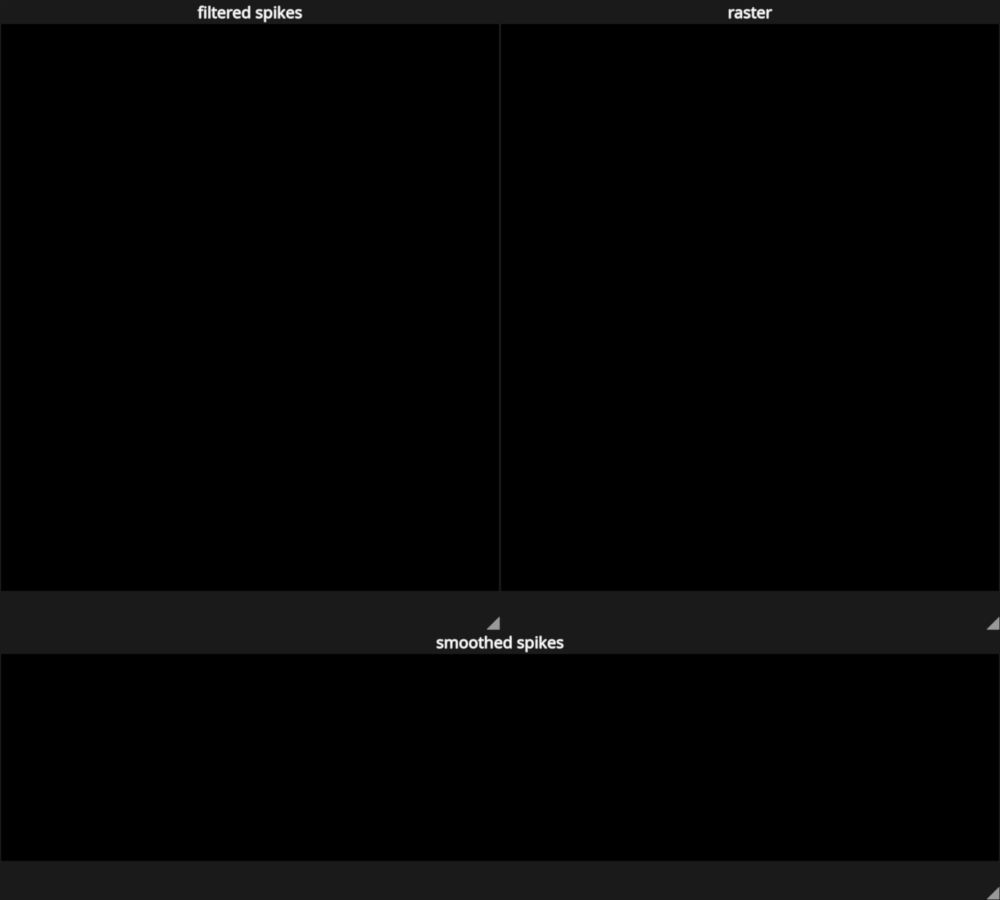

In [12]:
figure.show()

In [13]:
# Add the animation update function
figure.add_animations(update_figure)

In [ ]:
figure.canvas.get_stats()